# Project Overview

**1. Project Objective:**  
The aim of the project was to examine readability measures and sentiment values ​​for texts generated using first-degree Markov chains.

**2. Project Steps:**
- The initial steps (1-3) are preparatory. The texts are downloaded from the listed URLs and then combined into a whole. A **200-word excerpt** is selected, which serves as a **starting point** for further analysis.
- **Step 4:** Functions for **sentiment and readability analysis** are created.
- In the next step, the sentiment of **each word** in the text is analyzed, and results are stored in a **data frame**.
- A function is then created to **generate text using Markov chains**.
- **Step 7:** Two texts are generated using Markov chains - one positive and one negative.
- Finally, **sentiment analysis is performed**, and **charts & descriptions of calculated measures** are generated for further analysis.


In [1]:
#Installation of necessary packages
%pip install textstat textblob

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import random
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import requests
import textstat

#Step 1: Initialize Spark session
spark = SparkSession.builder.appName("TextAnalysisAndGeneration").getOrCreate()

#Step 2: Download texts and combine them into one text
urls = [
    "https://www.gutenberg.org/files/2701/old/moby10b.txt",  # Moby-Dick by Herman Melville
    "https://www.gutenberg.org/cache/epub/98/pg98.txt",  # A Tale of Two Cities by Charles Dickens
    "https://web.stanford.edu/class/cs110/examples/cpp-primer/anna-karenina.txt",  # Anna Karenina by Leo Tolstoy
    "https://www.gutenberg.org/files/1342/1342-0.txt",  # Pride and Prejudice by Jane Austen
    "https://gutenberg.net.au/ebooks02/0200041.txt",  # The Picture of Dorian Gray by Oscar Wilde
    "https://www.gutenberg.org/files/2554/2554-0.txt",  # Crime and Punishment by Fyodor Dostoyevsky
    "https://www.gutenberg.org/files/1661/1661-0.txt",  # The Adventures of Sherlock Holmes by Arthur Conan Doyle
    "https://www.gutenberg.org/files/120/120-0.txt",  # Treasure Island by Robert Louis Stevenson
    "https://www.gutenberg.org/files/768/768-0.txt",  # Wuthering Heights by Emily Brontë
    "https://www.gutenberg.org/files/1400/1400-0.txt",  # Great Expectations by Charles Dickens
    "https://www.gutenberg.org/files/25344/25344-0.txt",  # The Scarlet Letter by Nathaniel Hawthorne
]


def load_text_from_urls(url_list):
    texts = []
    for url in url_list:
        response = requests.get(url)
        if response.status_code == 200:
            texts.append(response.text)
        else:
            print(f"Failed to retrieve text from {url}")
    combined_text = "\n".join(texts)
    return combined_text.split(". ")

original_sentences = load_text_from_urls(urls)

# Step 3: Select a sample of the original text (~200 words)
def get_text_sample(sentences, word_limit=200):
    middle_index = len(sentences) // 10
    text_sample = []
    word_count = 0

    for sentence in sentences[middle_index:]:
        words = sentence.split()
        word_count += len(words)
        text_sample.append(sentence)
        if word_count >= word_limit:
            break

    return " ".join(text_sample)

original_fragment = get_text_sample(original_sentences)

# Step 4: Helper functions for text analysis
def analyze_text_sentiment(text):
    """Sentiment analysis for the full text."""
    return TextBlob(text).sentiment.polarity

def compute_readability(text):
    """Calculate text readability indices."""
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(text),
        "Automated Readability Index": textstat.automated_readability_index(text),
        "SMOG Index": textstat.smog_index(text)
    }

# Step 5: Word sentiment analysis
words_rdd = spark.sparkContext.parallelize(list(set(" ".join(original_sentences).split())))

def analyze_word_sentiment(word):
    """Sentiment analysis of a single word."""
    return (word, TextBlob(word).sentiment.polarity)

sentiment_rdd = words_rdd.map(analyze_word_sentiment)
sentiment_data = sentiment_rdd.collect()

sentiment_df = spark.createDataFrame(sentiment_data, ["word", "sentiment"])
sentiment_df = sentiment_df.withColumn(
    "sentiment_class",
    when(col("sentiment") > 0, "positive")
    .when(col("sentiment") < 0, "negative")
    .otherwise("neutral")
)

original_sentiment = analyze_text_sentiment(original_fragment)
original_readability = compute_readability(original_fragment)

# Step 6: Train Markov Model
class MarkovChain:
    def __init__(self):
        self.model = {}

    def train(self, sentences):
        """Train the Markov model using the provided sentences."""
        for sentence in sentences:
            words = sentence.split()
            for i in range(len(words) - 1):
                if words[i] not in self.model:
                    self.model[words[i]] = []
                self.model[words[i]].append(words[i + 1])

    def generate(self, first_word=None, length=200):
        """Generate text using the Markov model."""
        if not first_word or first_word not in self.model:
            first_word = random.choice(list(self.model.keys()))
        result = [first_word]
        for _ in range(length - 1):
            if result[-1] not in self.model or not self.model[result[-1]]:
                break
            next_word = random.choice(self.model[result[-1]])
            result.append(next_word)
        return " ".join(result)

sentences_rdd = spark.sparkContext.parallelize(original_sentences)

def train_partition(partition):
    local_chain = MarkovChain()
    local_chain.train(partition)
    return [local_chain.model]

models_rdd = sentences_rdd.mapPartitions(train_partition)
distributed_model = models_rdd.reduce(lambda a, b: {**a, **b})

markov_chain = MarkovChain()
markov_chain.model = distributed_model

# Step 7: Generating text for each sentiment class
def generate_large_text(sentiment_class, length=1500, min_length=600, max_attempts=100):

    if sentiment_class == "positive":
        seed_words = sentiment_df.filter(col("sentiment_class") == "positive").select("word").rdd.flatMap(lambda x: x).collect()
    else:
        seed_words = sentiment_df.filter(col("sentiment_class") == "negative").select("word").rdd.flatMap(lambda x: x).collect()

    attempts = 0
    while attempts < max_attempts:
        seed_word = random.choice(seed_words) if seed_words else None
        generated_text = markov_chain.generate(first_word=seed_word, length=length)

        if len(generated_text.split()) >= min_length:
            return generated_text

        attempts += 1

    return generated_text

large_positive_text = generate_large_text("positive")
large_negative_text = generate_large_text("negative")




In [4]:
# Samples of generated texts and original text sample

# Max 70 characters per line
def format_text(text, max_length=70):
    words = text.split()
    lines = []
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            lines.append(current_line)
            current_line = word
        else:
            current_line += " " + word if current_line else word

    if current_line:
        lines.append(current_line)

    return "\n".join(lines)

# Displaying the generated texts and original text sample
print("=" * 80)
print("\n📌 Sample of Positive Text:")
print(format_text(large_positive_text[:1500]))
print("=" * 80)

print("\n📌 Sample of Negative Text:")
print(format_text(large_negative_text[:1500]))
print("=" * 80)

print("\n📌 Sample of the Original Text:")
print(original_fragment)
print("=" * 80)




📌 Sample of Positive Text:
calm--“can’t you are usually committed to remain another minute before
his head, and by one has no shadow of coming along its folly, far from
the midst of positive I didn’t believe my master of sand which I see
him snap off hanging to be the tavern, a child!” said Holmes nodded
again, until sleep that case, and astonishment, “how much?” “Thirty
copecks,” the trees and I am! Had I must raise the settle, and nearer
to Halifax, when he sealed orders are brought me, there is not
tortured by very beginning, “I used to all eyes made a lad should
recover it all! All this young man who had come to take place there,
just taking their state of the figure was succeeded in to live
horseshoe by no one another year ago from the grass which Providence
had never meant to know.” “You are five and convincing sound became a
eel!” At the petted will. On every thought of our humble sheds on fire
spinning through the way to me (as we reached a log of my existence,
and took up a c

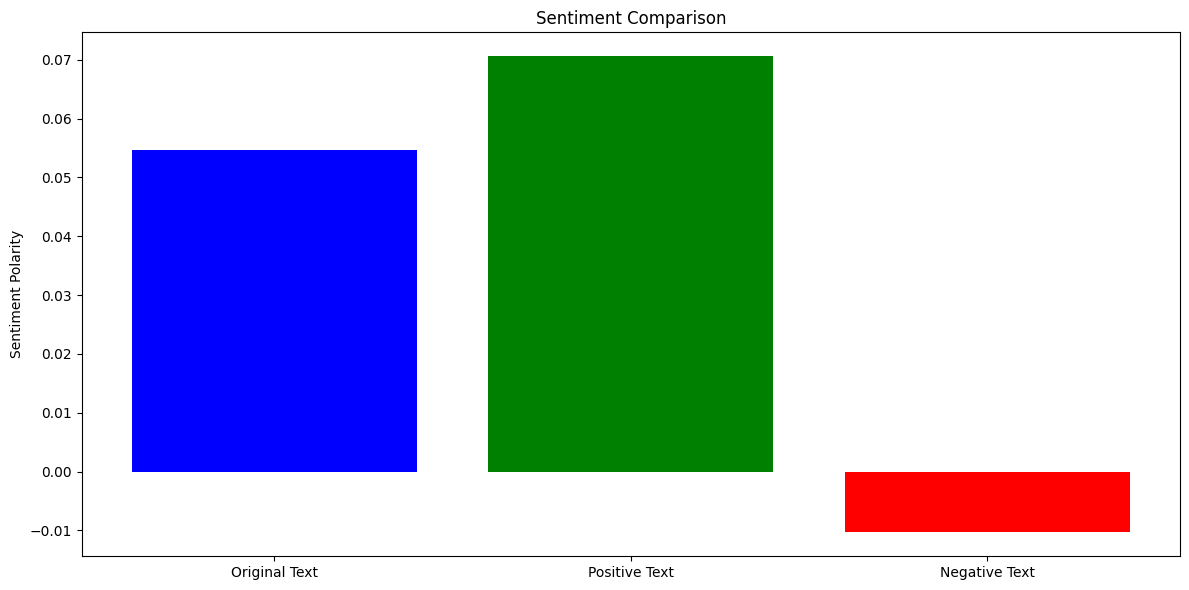

In [5]:
# Step 8: Sentiment Analysis on RDD
generated_rdd = spark.sparkContext.parallelize([large_positive_text, large_negative_text])
sentiment_results = generated_rdd.map(analyze_text_sentiment).collect()

positive_sentiment = sentiment_results[0]
negative_sentiment = sentiment_results[1]

# Step 9: Generating Sentiment Comparison Plot
plt.figure(figsize=(12, 6))
plt.bar(
    ["Original Text", "Positive Text", "Negative Text"],
    [original_sentiment, positive_sentiment, negative_sentiment],
    color=["blue", "green", "red"]
)
plt.ylabel("Sentiment Polarity")
plt.title("Sentiment Comparison")
plt.tight_layout()
plt.show()



In [6]:
# Displaying sentiment results
print("=" * 40)
print(f"📈 Average Sentiment of Texts:")
print(f"📌 Original Text: {original_sentiment:.3f}")
print(f"✅ Sentiment of Positive Text: {positive_sentiment:.3f}")
print(f"❌ Sentiment of Negative Text: {negative_sentiment:.3f}")
print("=" * 40)

📈 Average Sentiment of Texts:
📌 Original Text: 0.055
✅ Sentiment of Positive Text: 0.071
❌ Sentiment of Negative Text: -0.010


The results indicate that the original text has a slightly positive sentiment with a value of 0.055. The generated positive text successfully reflects a stronger positive sentiment at 0.071, showing that the Markov chain model effectively preserves sentiment tendencies when seeded with positive words. Meanwhile, the negative text, although intended to be more negative, only reached a sentiment score of -0.010, suggesting that the model struggles to generate strongly negative content. This could be due to the distribution of sentiment in the training data or the limitations of single-degree Markov chains in maintaining long-term sentiment coherence.

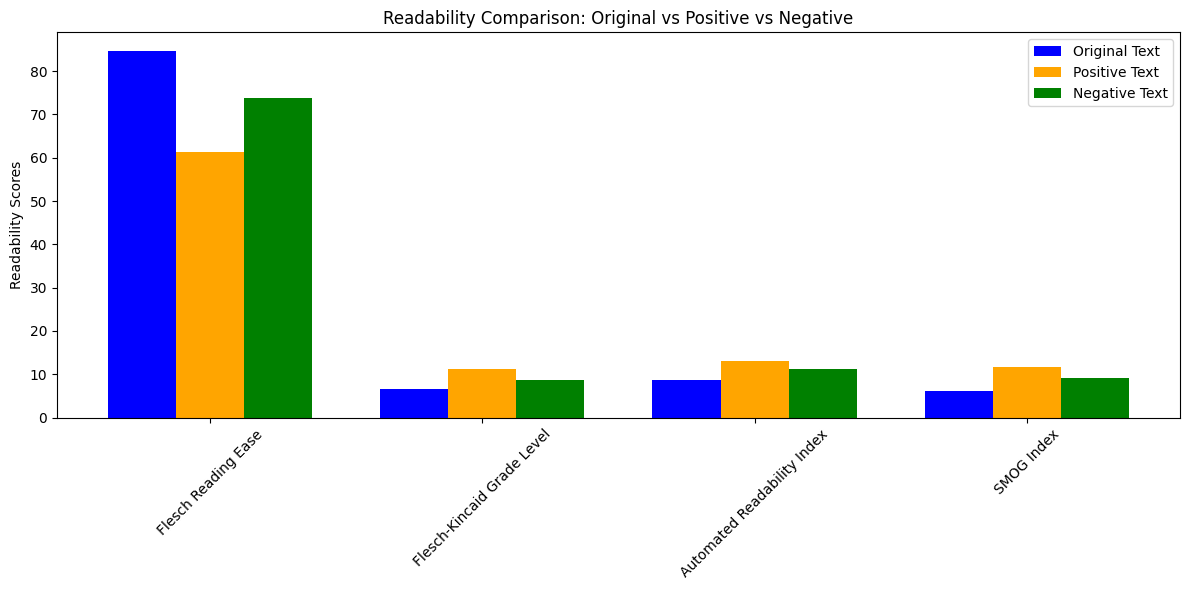

In [7]:
# Calculating readability scores for the generated large texts
positive_avg_readability = compute_readability(large_positive_text)
negative_avg_readability = compute_readability(large_negative_text)

# Creating lists for the readability comparison plot
labels = list(original_readability.keys())
original_values = list(original_readability.values())
positive_avg_values = list(positive_avg_readability.values())
negative_avg_values = list(negative_avg_readability.values())

# Readability comparison chart
plt.figure(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.25

plt.bar(x - width, original_values, width, label="Original Text", color="blue")
plt.bar(x, positive_avg_values, width, label="Positive Text", color="orange")
plt.bar(x + width, negative_avg_values, width, label="Negative Text", color="green")

plt.ylabel("Readability Scores")
plt.title("Readability Comparison: Original vs Positive vs Negative")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [8]:
# Displaying readability statistics
print("\n📊 Average Readability Statistics for Generated Texts:")
print("=" * 55)

print("\n📖 Readability of the Positive Text:")
for key, value in positive_avg_readability.items():
    print(f"   {key}: {value:.2f}")

print("\n📖 Readability of the Negative Text:")
for key, value in negative_avg_readability.items():
    print(f"   {key}: {value:.2f}")

print("\n📖 Readability of the Original Text Sample:")
for key, value in original_readability.items():
    print(f"   {key}: {value:.2f}")




📊 Average Readability Statistics for Generated Texts:

📖 Readability of the Positive Text:
   Flesch Reading Ease: 61.29
   Flesch-Kincaid Grade Level: 11.30
   Automated Readability Index: 13.10
   SMOG Index: 11.70

📖 Readability of the Negative Text:
   Flesch Reading Ease: 73.81
   Flesch-Kincaid Grade Level: 8.60
   Automated Readability Index: 11.10
   SMOG Index: 9.20

📖 Readability of the Original Text Sample:
   Flesch Reading Ease: 84.71
   Flesch-Kincaid Grade Level: 6.50
   Automated Readability Index: 8.60
   SMOG Index: 6.10


The readability analysis shows that the original text is the easiest to read, with the highest Flesch Reading Ease score (84.71) and the lowest grade-level metrics. The negative text is more complex but still accessible, with a Flesch score of 73.81. The positive text, however, is the most difficult to read, with a Flesch score of 61.29 and higher grade-level values.